In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial
from matplotlib import colormaps as cm

In [2]:
# from jax import config
# config.update("jax_enable_x64", True)

In [3]:
L = 1.
NX = NY = 64
X_START = 0.
X_END = L
Y_START = 0.
Y_END = L
T_START = 0.
T_END = 10.
dt = 1e-3
NT = int((T_END - T_START)/dt)
TOL = 1e-5
TOL_poisson = 1e-5
Re = 100.0

## Space-Time Domain

In [4]:
x = jnp.linspace(X_START, X_END, NX + 1)
y = jnp.linspace(Y_START, Y_END, NY + 1)
X, Y = jnp.meshgrid(x, y)

In [5]:
t = jnp.linspace(T_START, T_END, NT + 1)

In [6]:
dx = x[1] - x[0]
dy = y[1] - y[0]

## Initial condition for vorticity and streamfunction

In [7]:
psi_init = jnp.zeros((NX+1, NY+1))
omega_init = jnp.zeros((NX+1, NY+1))
omega_psi_init = jnp.stack((omega_init, psi_init))

In [8]:
@jax.jit
def residual_node_compute(i, j, u, f, dx=dx, dy=dy):
    u_ijm1, u_ij, u_ijp1, u_im1j, u_ip1j, f_ij = u[i,j - 1], u[i,j],  u[i,j + 1], u[i - 1,j], u[i + 1,j], f[i,j]
    return f_ij - (u_ijp1 - 2*u_ij + u_ijm1)/dx**2 - (u_ip1j - 2*u_ij + u_im1j)/dy**2

@jax.jit
def q_node_compute(i, j, u, dx=dx, dy=dy):
    u_ijm1, u_ij, u_ijp1, u_im1j, u_ip1j = u[i,j - 1], u[i,j],  u[i,j + 1], u[i - 1,j], u[i + 1,j]
    return (u_ijp1 - 2*u_ij + u_ijm1)/dx**2 + (u_ip1j - 2*u_ij + u_im1j)/dy**2

In [9]:
# pre-processing data for CG method
@jax.jit
def cg_preprocessor(omega, psi,index_x=jnp.arange(1, NX), index_y=jnp.arange(1, NY)):
    rnc = lambda i, j : residual_node_compute(i, j, psi, -omega)
    rnc_vmapped = jax.vmap(jax.vmap(rnc, in_axes=(None, 0)), in_axes=(0, None))
    
    psi_r = jnp.zeros_like(psi)
    psi_r = psi_r.at[1:-1, 1:-1].set(rnc_vmapped(index_x, index_y))
    psi_p = jnp.copy(psi_r)
    
    return jnp.stack((psi, psi_r, psi_p))

In [10]:
# Poisson Solver using Cojugate Gradient
def cg_main_loop(urp, index_arr_x=jnp.arange(1,NX), index_arr_y=jnp.arange(1,NY)):
    u, r, p = urp
    
    q = jnp.zeros_like(p)
    q = q.at[1:-1, 1:-1].set(jax.vmap(jax.vmap(q_node_compute, in_axes=(None, 0, None)),\
                            in_axes=(0, None, None))\
                            (index_arr_x, index_arr_y, p))
    rho = jnp.sum(r * r)
    alpha = rho/jnp.sum(p * q)
    
    u = u.at[1:-1, 1:-1].add(alpha * p[1:-1, 1:-1])
    r = r.at[1:-1, 1:-1].add(-alpha * q[1:-1, 1:-1])
    
    rho_new = jnp.sum(r * r)
    beta = rho_new/rho
    p = p.at[1:-1, 1:-1].set(r[1:-1, 1:-1] + beta * p[1:-1, 1:-1])

    return jnp.stack((u, r, p), axis=0)
    
def tol_check(urp, tol=TOL_poisson):
    _, r, __ = urp
    return jnp.sqrt(jnp.average(jnp.square(r))) > tol

In [11]:
conj_grad = lambda psi_urp_init: jax.lax.while_loop(tol_check, cg_main_loop, psi_urp_init)[0]

In [12]:
# boundary conditions for vorticity (second-order method)
@jax.jit
def bound_cond(omega, psi, dx=dx, dy=dy):
    omega = omega.at[0, :].set((-4. * psi[1, :] + 0.5 * psi[2, :])/dx**2)
    omega = omega.at[-1, :].set((-4. * psi[-2, :] + 0.5 * psi[-3, :])/dx**2)
    omega = omega.at[:, 0].set((-4. * psi[:, 1] + 0.5 * psi[:, 2])/dy**2)
    omega = omega.at[:, -1].set((-4. * psi[:, -2] + 0.5 * psi[:, -3])/dy**2 - (3./dy))
    return omega   

In [13]:
# rhs of the naiver stokes equation (Arakawa numerical scheme for Jacobian)
@jax.jit
def ns_rhs(i, j, omega, psi, dx=dx, dy=dy, Re=Re):
    
    aa = 1./(Re*dx**2)
    bb = 1./(Re*dy**2)
    gg = 1./(4.*dx*dy)
    hh = 1./3.
    
    j1 = gg*((omega[i+1,j] - omega[i-1,j])*(psi[i,j+1] - psi[i,j-1]) -\
             (omega[i,j+1] - omega[i,j-1])*(psi[i+1,j] - psi[i-1,j]))
    
    j2 = gg*((omega[i+1,j]*(psi[i+1, j+1] - psi[i+1, j-1])) -\
             (omega[i-1,j]*(psi[i-1, j+1] - psi[i-1, j-1])) -\
             (omega[i,j+1]*(psi[i+1, j+1] - psi[i-1, j+1])) +\
             (omega[i,j-1]*(psi[i+1, j-1] - psi[i-1, j-1])))
    
    j3 = gg*((omega[i+1,j+1]*(psi[i, j+1] - psi[i+1, j])) -\
             (omega[i-1,j-1]*(psi[i-1, j] - psi[i, j-1])) -\
             (omega[i-1,j+1]*(psi[i, j+1] - psi[i-1, j])) +\
             (omega[i+1,j-1]*(psi[i+1, j] - psi[i, j-1])))
    
    jac = (j1+j2+j3)*hh
    
    return -jac + aa*(omega[i+1,j] - 2.*omega[i,j] + omega[i-1, j]) +\
                  bb*(omega[i,j+1] - 2.*omega[i,j] + omega[i, j-1])

@jax.jit                 
def rhs_processed(omega, psi, index_x=jnp.arange(1, NX), index_y=jnp.arange(1, NY)):
       ns_rhs_spec = lambda i, j: ns_rhs(i, j, omega=omega, psi=psi)
       ns_rhs_spec_vmapped = jax.vmap(jax.vmap(ns_rhs_spec, in_axes=(None, 0)), in_axes=(0, None))
       
       rhs = jnp.zeros_like(omega)
       return rhs.at[1:-1, 1:-1].set(ns_rhs_spec_vmapped(index_x, index_y))

In [14]:
# Time integration: RK-3 and Space-discretization: 2nd order finite difference
def solver_one_step(iter, omega_psi, dt=dt):
    omega, psi = omega_psi
    omega_temp = jnp.empty_like(omega)
    
    rhs = rhs_processed(omega, psi)
    omega_temp = omega_temp.at[1:-1, 1:-1].set(omega[1:-1, 1:-1] + dt*rhs[1:-1, 1:-1]) # first step RK
    omega_temp = omega_temp.at[:, :].set(bound_cond(omega_temp, psi)) # update boundary
    psi_urp = cg_preprocessor(omega_temp, psi)
    psi = psi.at[:, :].set(conj_grad(psi_urp)) # solve for psi
    
    rhs = rhs.at[:, :].set(rhs_processed(omega_temp, psi))
    omega_temp = omega_temp.at[1:-1, 1:-1].set(0.75*omega[1:-1, 1:-1] +\
                                               0.25*(omega_temp[1:-1, 1:-1]+ dt*rhs[1:-1, 1:-1])) # second step RK
    omega_temp = omega_temp.at[:, :].set(bound_cond(omega_temp, psi)) # update boundary
    psi_urp = psi_urp.at[:,:,:].set(cg_preprocessor(omega_temp, psi))
    psi = psi.at[:, :].set(conj_grad(psi_urp)) # solve for psi
    
    rhs = rhs.at[:, :].set(rhs_processed(omega_temp, psi))
    omega_temp = omega_temp.at[1:-1, 1:-1].set((1/3)*omega[1:-1, 1:-1] +\
                                               (2/3)*(omega_temp[1:-1, 1:-1]+ dt*rhs[1:-1, 1:-1])) # third step RK
    omega_temp = omega_temp.at[:, :].set(bound_cond(omega_temp, psi)) # update boundary
    psi_urp = psi_urp.at[:,:,:].set(cg_preprocessor(omega_temp, psi))
    psi = psi.at[:, :].set(conj_grad(psi_urp)) # solve for psi  
    
    return jnp.stack((omega_temp, psi))  
    
num_solver = lambda omega_psi, NT: jax.lax.fori_loop(0, NT, solver_one_step, omega_psi)

In [15]:
final_omega,final_psi = num_solver(omega_psi_init, NT)

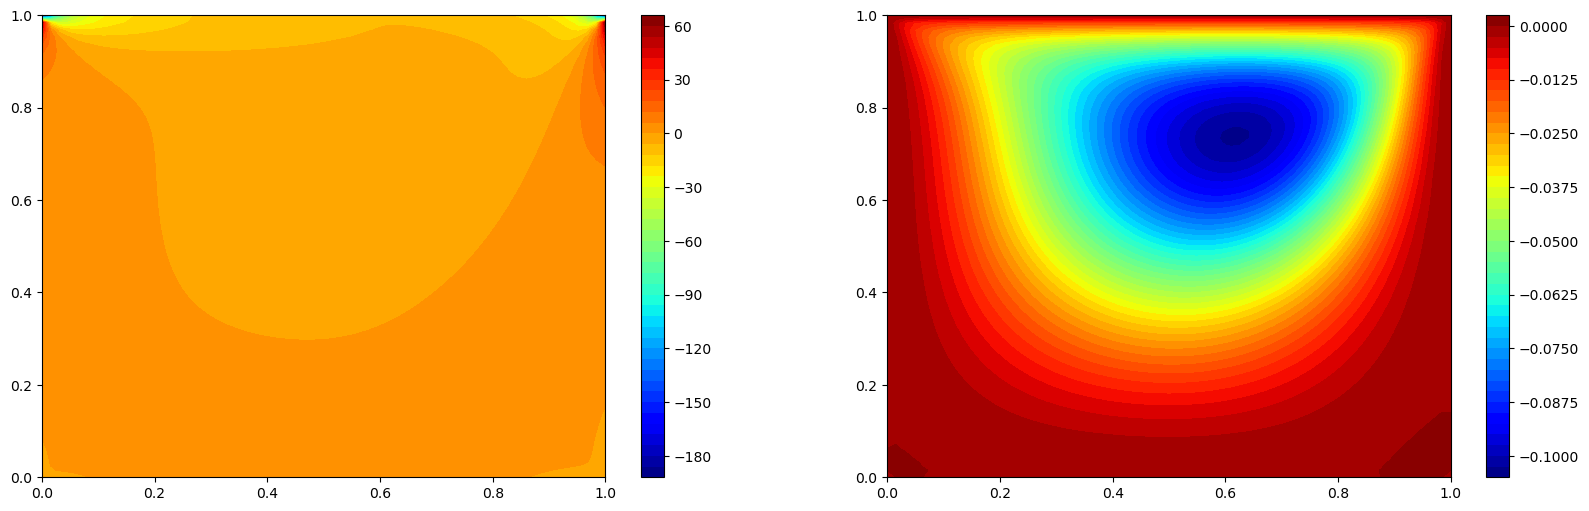

In [27]:
fig, axs = plt.subplots(1,2, figsize=(20, 6))
vorticity = axs[0].contourf(Y, X, final_omega, 50, cmap=cm.get_cmap('jet'))
stream_func = axs[1].contourf(Y, X, final_psi, 50, cmap=cm.get_cmap('jet'))

fig.colorbar(vorticity)
fig.colorbar(stream_func)
plt.show()